
Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm




Loading Jacobians...25.2s
[1] "...cross product"
[1] ".. .deriving posterior covariance matrix of state, P"
[1] "...deriving posterior mean state, X_hat"
[1] ""
[1] "************************************************************"
[1] "--Chi sq test on posterior residuals relative to S_z--"
[1] "************************************************************"
[1] "var est= 1.003  CI (stand variance, chi sq test):  ( 0.976 , 1.033 )"
[1] ""
[1] "************************************************************"
[1] "--Chi sq test on posterior vs truth, relative to S_xpost--"
[1] "************************************************************"
[1] "chi sq stat: 1.11076873220459"
[1] ""
[1] "*****************************************************************"
[1] "--Chi sq test: test variance of x_prior, relative to S_0--"
[1] "*****************************************************************"
[1] "chi sq stat: 1.08370251603557"
[1] "Done....writing inversion object output"
   [IC] chi2 means: state 1.1

Loading required package: plotrix



Loading priors integrated over Transcom regions...0.1s


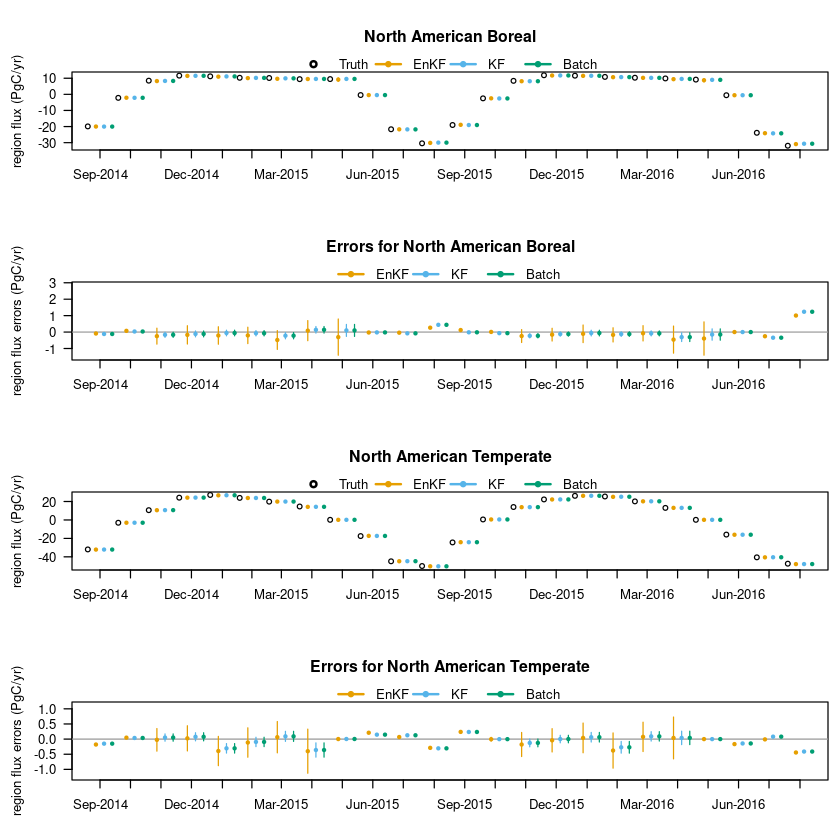

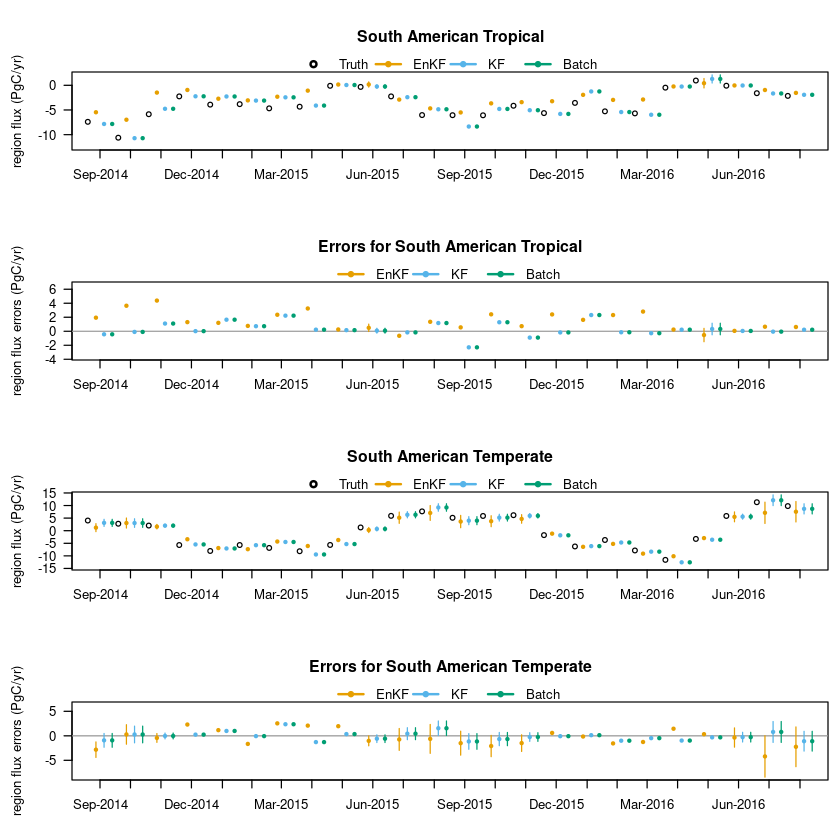

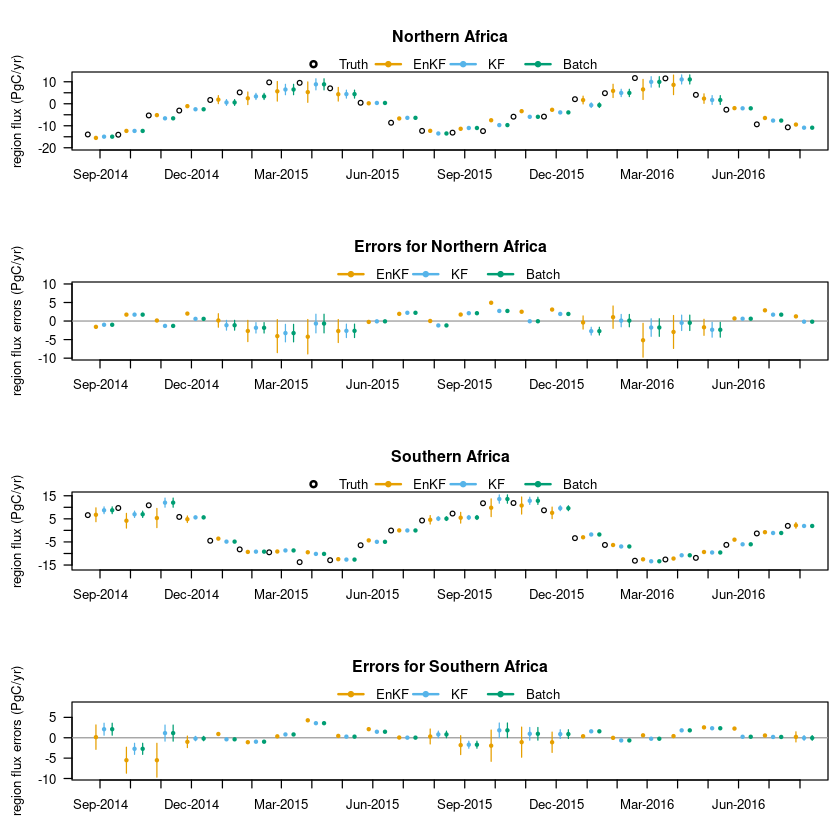

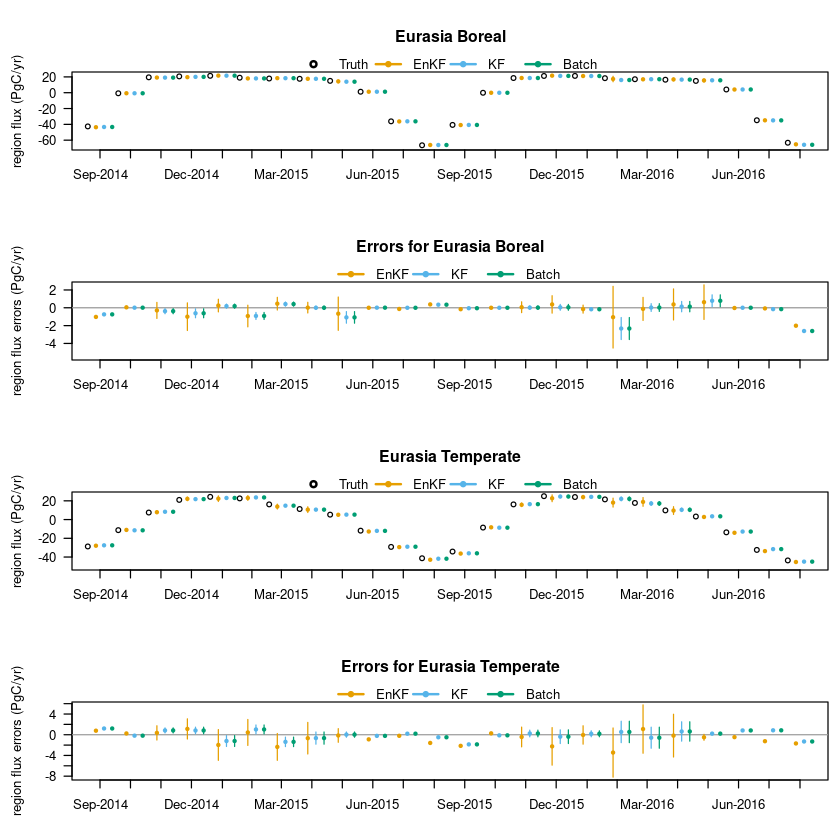

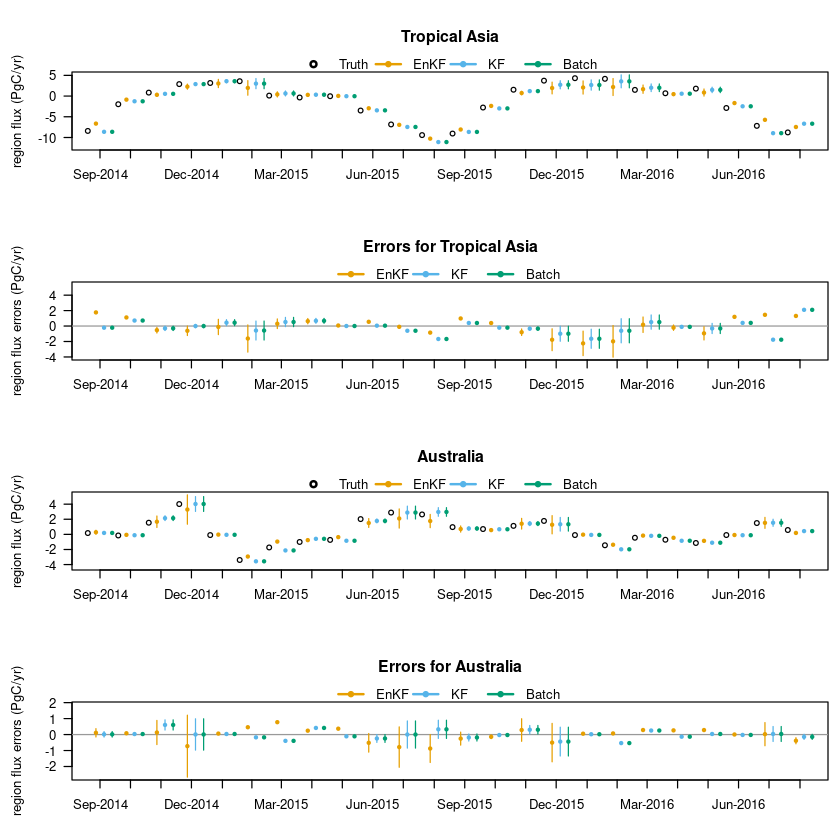

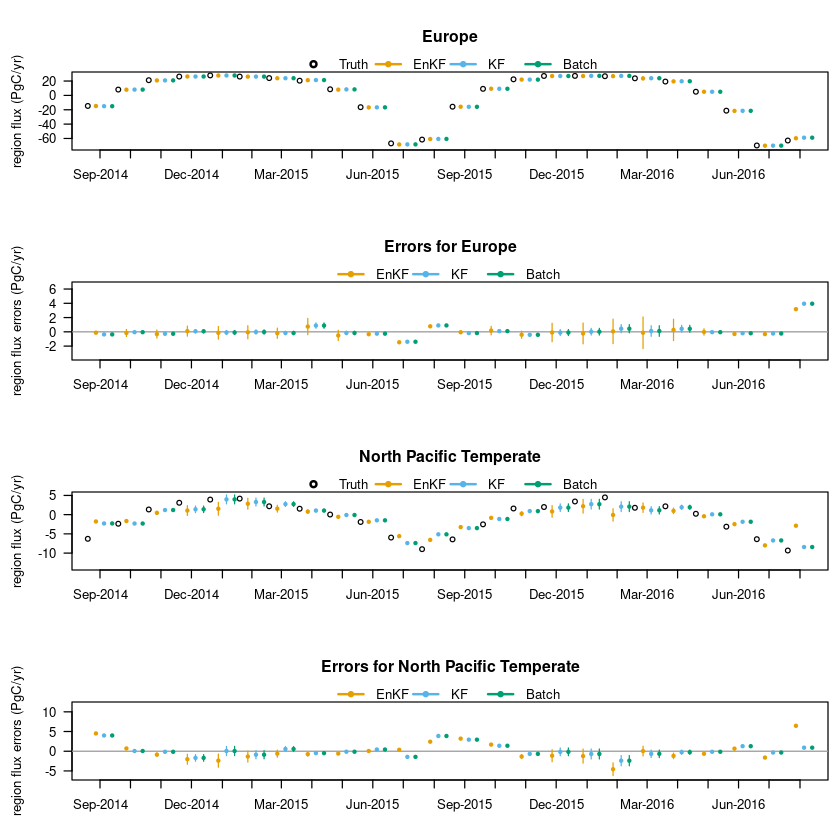

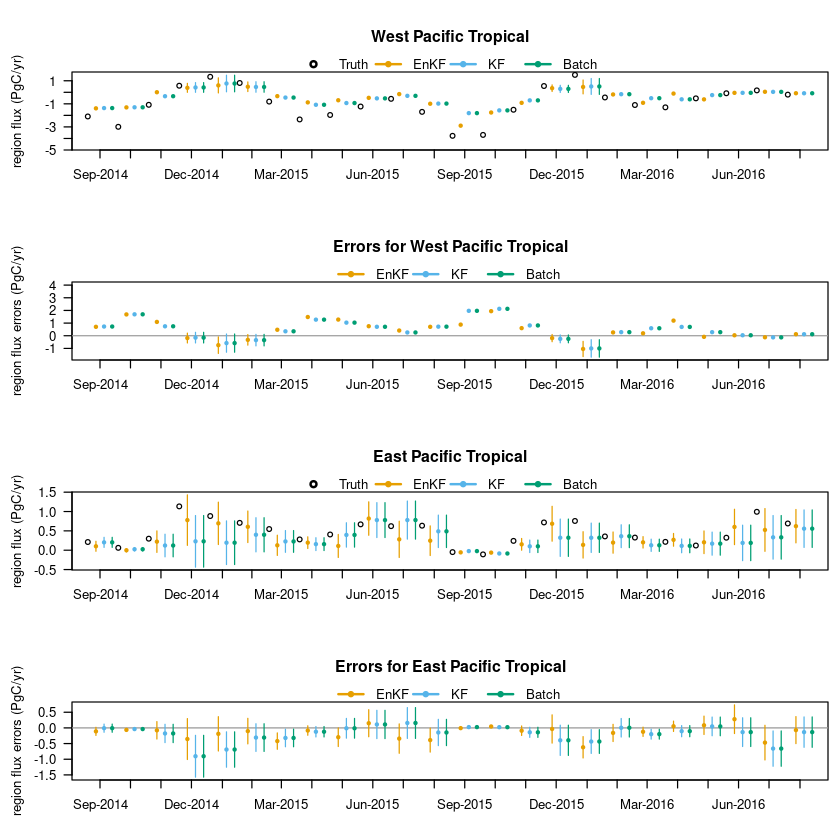

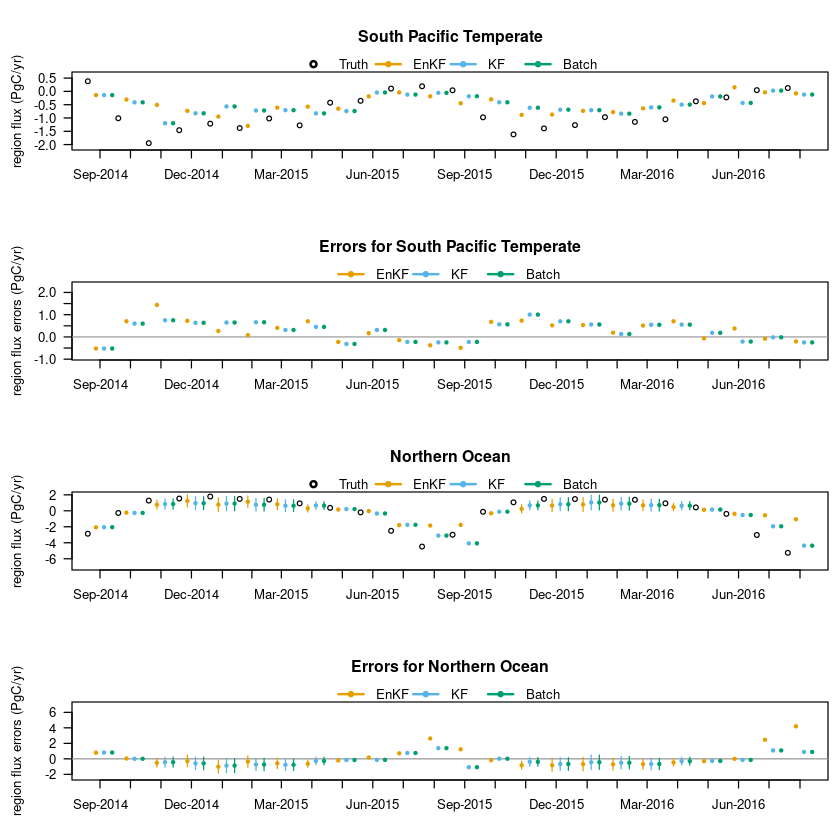

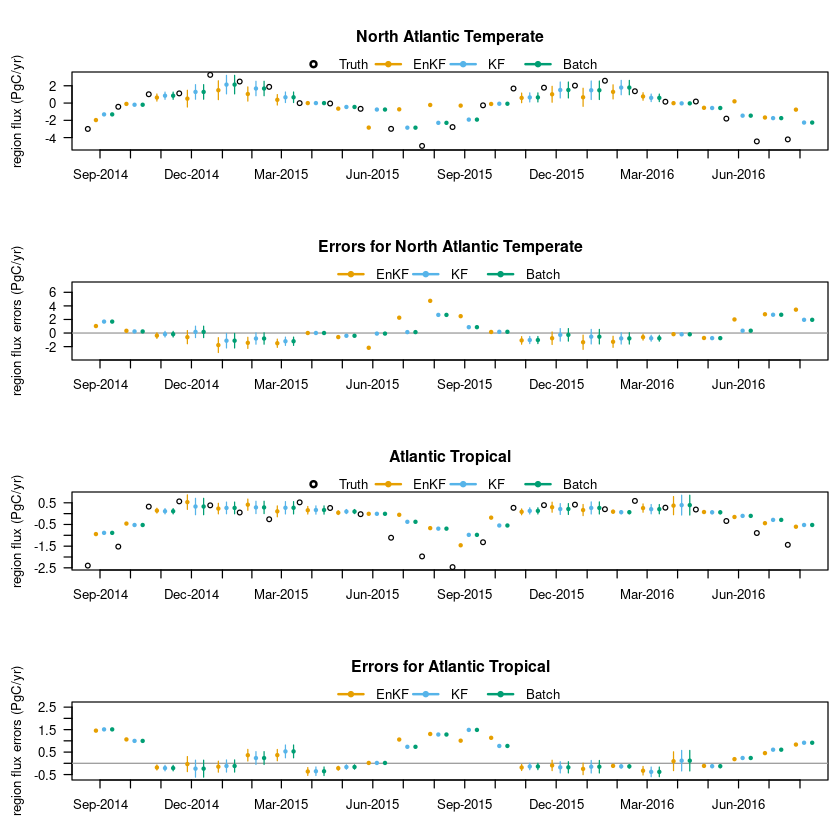

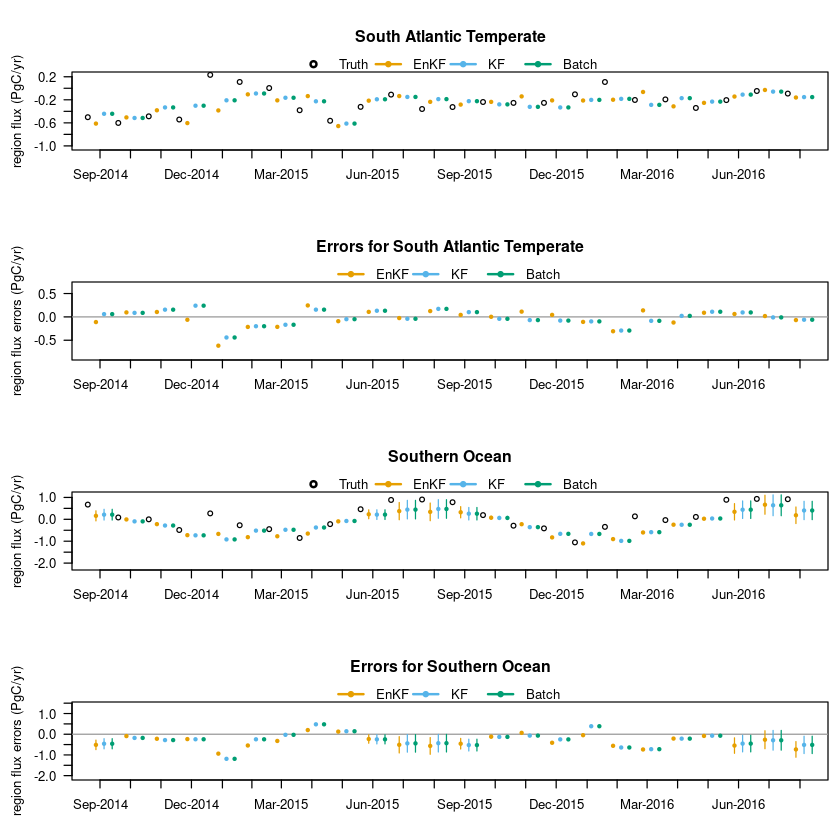

Loading obs_catalog...1.1s
co2_mlo_surface-insitu_1_allvalid: 3577 obs, from 2014-09-03 09:30:00 to 2016-08-30 12:00:00
co2_brw_surface-insitu_1_allvalid: 3550 obs, from 2014-09-01 19:30:00 to 2016-08-31 12:00:00
co2_smo_surface-insitu_1_allvalid: 2762 obs, from 2014-09-01 00:30:00 to 2016-08-31 12:00:00


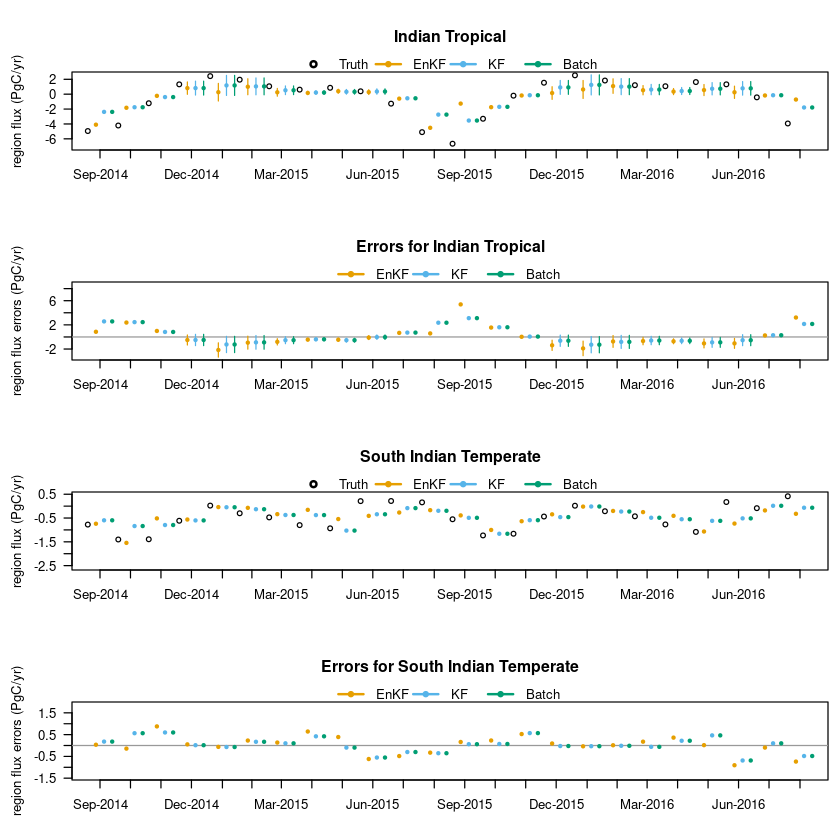

co2_spo_surface-insitu_1_allvalid: 5181 obs, from 2014-09-01 00:30:00 to 2016-08-31 12:00:00
co2_lef_tower-insitu_1_allvalid-396magl: 15976 obs, from 2014-09-01 00:30:00 to 2016-08-31 12:00:00


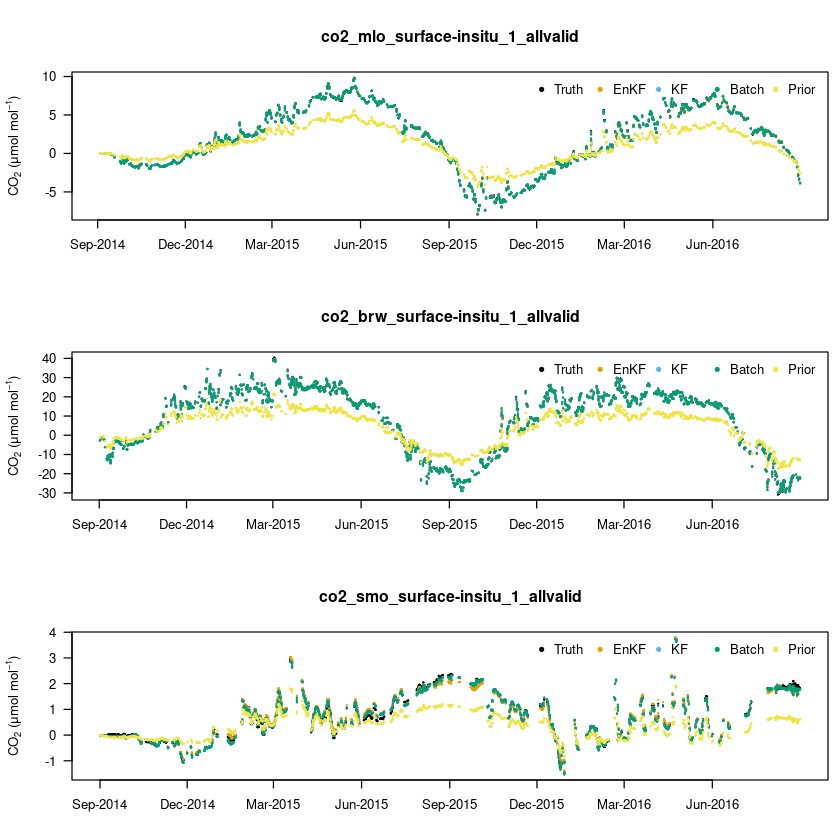

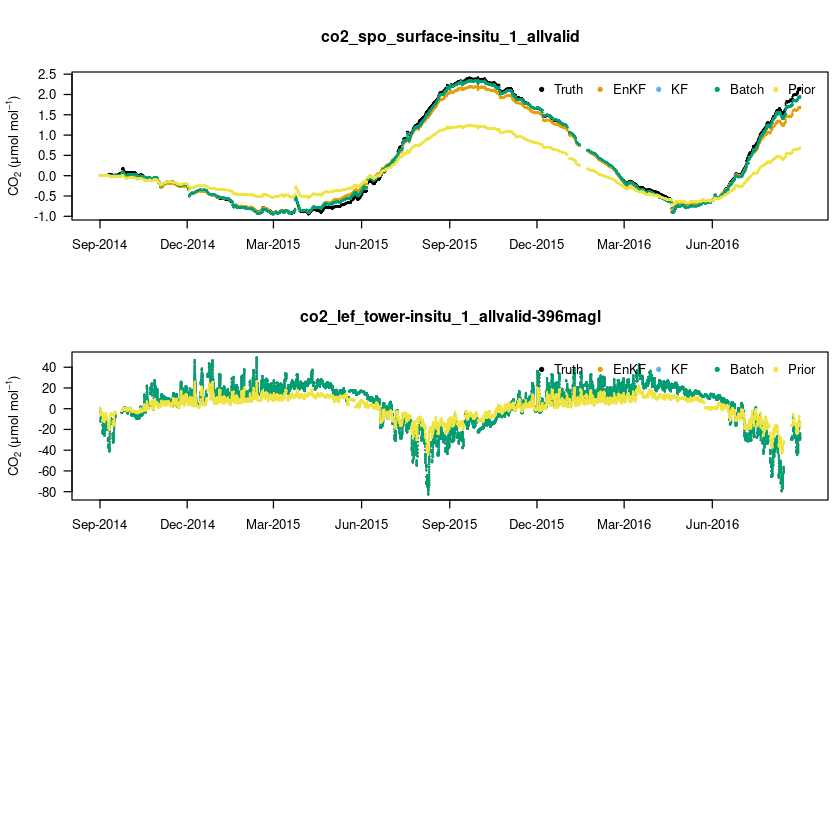

In [1]:
# Time-stamp: <hercules-login-4.hpc.msstate.edu:/work/noaa/co2/andy/Projects/enkf_summer_school/repo/ssim-ghg-2024/EnKF/base/MIP_sfs.r: 07 Jun 2024 (Fri) 21:05:47 UTC>

# This code applies the EnKF measurement update to a truth condition
# generated from scaling factors derived from OCO-2 v10 MIP models.

#source("../tools/invert_clean.r")
source("../tools/enkf.r")
source("../tools/progress.bar.r")
source("../tools/find.indir.r")
source("../tools/time.r")
source("../tools/load.ncdf4.r")
#source("../../batch/inversion_032024.R") # for Andrew's invert_clean function
source("../tools/inversion_032024_nobgd.R") # for Andrew's invert_clean function
source("../../batch/util_code_032024.R") # for Andrew's ar_covariance function
indir <- find.indir()

# Add local library for R packages
.libPaths(new=c(sprintf("%s/shared/lib/R-4.3/x86_64-pc-linux-gnu",Sys.getenv("HOME")),.libPaths())) 

options(warn=2)
library(Matrix)
library(ncdf4)
library(EnvStats)

# Load sensitivity matrices (Jacobians)
t0 <- proc.time()[3]
cat("Loading Jacobians...")
load(file.path(indir,"inversion_examples/jacobians/trunc_full_jacob_030624_with_dimnames_sib4_4x5_mask.rda"))
#load(file.path(indir,"inversion_examples/jacobians/jacob_bgd_021624.rda"))
H <- jacob*(12/44) # Andrew reports units conversion needed
#H_fixed <- jacob_bgd[,c(2,3)]
#rm(jacob,jacob_bgd)
rm(jacob)

# We'll be subsetting H later; preserve the original matrices in the
# H.orig list for later use.
H.orig <- H

cat(sprintf('%.1fs\n',proc.time()[3]-t0))

nobs <- dim(H)[1]

# One question often asked is what happens if we get the MDM
# wrong. You can check that below, by changing Szd.assumed to be
# different from Szd.actual.

# "d" suffix means its the diagonal (of a diagonal matrix)
Szd.actual <- rep((0.5)^2,nobs) # variance in ppm^2
#Szd.assumed <- rep((0.1)^2,nobs) # variance in ppm^2
Szd.assumed <- Szd.actual

# For this example, EnKF approaches the best answer (that of KF) for
# an ensemble of about 8000. If the ensemble is smaller, the
# chisq-state is less than 1.0, meaning that the uncertainties are too
# large compared with the actual state errors. (Large chisq-state
# means the opposite of course--underestimated uncertainties.)
nmemb <- 1000

nparms <- 22*24 # 22 regions, 24 months

if(FALSE) {
  land_prior_sd = 1.6
  ocean_prior_sd = 1.2
  #-- This will set up a prior temporal correlation
  Sx = bdiag(rep(list(ar_covariance(24, 0.5)), 22))
  #-- scale by variance for land/ocean
  var_scaling_diagonal = diag(c(rep(land_prior_sd,24*11),rep(ocean_prior_sd,24*11)))
  Sx = as.matrix(var_scaling_diagonal %*% Sx %*% t(var_scaling_diagonal))
} else {
  Sx <- diag(rep(1.2,nparms))
}
Sx.prior <- Sx

x.prior <- matrix(1,nrow=nparms,ncol=1) # prior central value: 1.0 is close to unbiased guess (0 would be biased)
dx.prior <- generate_ensemble(Sx=Sx.prior,nmemb=nmemb) # prior deviations

# Load MIP scaling factors for truth condition
load(file.path(indir,"inversion_examples/misc/truth_array.rda"))

# Andrew uses a tm() function to limit the range of values in an
# array. This function does the same but is very explicit. Note that
# the which() function temporarily casts x from a multidimensional
# array to a vector, and the x[lx] assignment does the same. The
# dimensions attribute of x is unaffacted, so the array size is
# unaffected. 
trim <- function(x,limits) {
  if(length(limits)!=2) {
    stop("Expecting 2-vector for limits argument")
  }
  lx <- which(x < limits[1])
  if(length(lx)>0) {
    x[lx] <- limits[1]
  }
  lx <- which(x > limits[2])
  if(length(lx)>0) {
    x[lx] <- limits[2]
  }
  return(x)
}

truth_condition <- -1 * trim(truth_array[1:24,2:23,1,1],c(-2,2))
tc.save <- truth_condition
dim(truth_condition) <- c(nparms,1) 
# Finally, add back the 1.0 that Andrew removed
truth_condition <- truth_condition + 1.0

# original (non-subsetted) no. obs is defined by the number of rows in
# the H (Jacobian) matrix.
nobs <- dim(H)[1]

# Note that supplying a Szd argument to the simulate_observed function
# will result in perturbations being added to the observations.  This
# would be the place to add biases to obs.
obs <- simulate_observed(H=H, x=truth_condition,Szd=Szd.actual)
obs.all <- obs # save original obs vector to send to invert_clean
dim(obs) <- c(nobs,1)


# Restrict to nobs randomly sampled subset of measurements. Could use
# obs_catalog or row.names of H to do more systematically-chosen
# subsets.
nobs.subset <- 10000

# lx is a vector of indices into the original 1:nobs 
#lx <- sample(x=1:length(obs),size=nobs.subset)
lx <- seq(1,nobs,length.out=nobs.subset) # fixed sequence
lx.obs.save <- lx

# subset all the arrays
obs <- obs[lx,]
Szd.assumed <- Szd.assumed[lx]
Szd.actual <- Szd.actual[lx]
H <- H[lx,]

# We use "nobs" below, so we need to update it
nobs <- nobs.subset

# generate prior simulated obs and obs deviations corresponding to
# x.prior and dx.prior parameter deviations.

y.prior <- simulate_observed(H=H,x=x.prior)

dy.prior <- t(simulate_observed(H=H,x=t(dx.prior)))

# The rejection and localization procedures are (currently) both
# serial loops over nobs and are therefore very slow. They are
# amenable to trivial parallelization, but this is not yet
# implemented. They also can be combined into one procedure, which is
# what we do operationally.

reject.outliers <- FALSE
localize <- FALSE

if(reject.outliers) {
  rej.mask <- find_outliers(y=y.prior,dy=dy.prior,obs=obs,
                            r=Szd.assumed)

  if(any(rej.mask==1)) {
    cat(sprintf("%d observations rejected as outliers\n",
                length(which(rej.mask==1))))
    lx <- which(rej.mask==0) # these are the ones to keep
    nobs <- length(lx)
    dy.prior <- dy.prior[lx,]
    y.prior <- y.prior[lx]
    obs <- obs[lx]
    Szd.assumed <- Szd.assumed[lx]
    Szd.actual <- Szd.actual[lx]
    H <- H[lx,]
  }
}


if(localize) {
  loc.mask <- localization_tval(dx=dx.prior,dy=dy.prior)
  
  cat(sprintf("%.1f%% of obs-parm relationships localized away.\n",
              100*length(which(as.vector(loc.mask)==0))/(nparms*nobs)))
} else {
  loc.mask <- NULL
}

enkf <- enkf_meas_update_loc(x=x.prior, dx=dx.prior,
                             obs=obs, Szd=Szd.assumed,
                             y=y.prior, dy=dy.prior,
                             localization_mask=loc.mask)

# compute sample covariance to represent posterior Sx
enkf$Sx <- cov(enkf$dx)

# Schuh invert_clean. Beware of different variable names.  Various
# quantities expected to have full original H matrix dimensions, so we
# create those here.
#
# The subset_indicator_obs logical vector can be used to subset the
# measurements. His R_diagonal is assumed to be a s.d. in ppm.
#
subset_indicator_obs=rep(FALSE,dim(H.orig)[1])
subset_indicator_obs[lx.obs.save] <- TRUE
R_diagonal=rep(0.5,dim(H.orig)[1])
R_diagonal[lx.obs.save] <- sqrt(Szd.assumed)
y=obs.all

batch <- invert_clean(H=H.orig,R_diagonal=R_diagonal,
                      P_0=Sx.prior,y=y,
                      subset_indicator_obs=subset_indicator_obs,
                      state_vector_true=truth_condition-1)

# Adding 1.0 to ic results because Andrew's code explicitly
# centers the scaling factors by subtracting 1.0
batch$posterior$x_hat <- batch$posterior$x_hat + 1

# Kalman filter measurement update
kf <- kf_meas_update(x=x.prior,Sx=Sx.prior,H=H,z=obs,
                     Sz=diag(Szd.assumed))

posterior.dofs <- FALSE

if(posterior.dofs) {
  ndofs.ic <- ndofs.patil(batch$posterior$P)
  ndofs.kf <- ndofs.patil(kf$Sx)
  ndofs.enkf <- ndofs.patil(enkf$Sx)
} else {
  ndofs.ic <- nparms
  ndofs.kf <- nparms
  ndofs.enkf <- nparms
}

chi2.state.kf <- (1/ndofs.kf) * t(kf$x - truth_condition) %*% solve(kf$Sx) %*% (kf$x - truth_condition)
chi2.prior.kf <- (1/nparms) * t(kf$x - x.prior) %*% solve(Sx.prior) %*% (kf$x - x.prior)
obs.kf.post <- simulate_observed(H=H,x=kf$x)
chi2.obs.kf <- (1/nobs) * t(obs - obs.kf.post) %*% diag(1/Szd.assumed) %*% (obs - obs.kf.post)

chi2.state.enkf <- (1/ndofs.enkf) * t(enkf$x - truth_condition) %*% solve(enkf$Sx) %*% (enkf$x - truth_condition)
chi2.prior.enkf <- (1/nparms) * t(enkf$x - x.prior) %*% solve(Sx.prior) %*% (enkf$x - x.prior)
obs.enkf.post <- simulate_observed(H=H,x=enkf$x)
chi2.obs.enkf <- (1/nobs) * t(obs - obs.enkf.post) %*% diag(1/Szd.assumed) %*% (obs - obs.enkf.post)

chi2.state.ic <- (1/ndofs.ic) * t(batch$posterior$x_hat - truth_condition) %*% solve(batch$posterior$P) %*% (batch$posterior$x_hat - truth_condition)
chi2.prior.ic <- (1/nparms) * t(batch$posterior$x_hat - x.prior) %*% solve(Sx.prior) %*% (batch$posterior$x_hat - x.prior)
obs.ic.post <- simulate_observed(H=H,x=batch$posterior$x_hat)
chi2.obs.ic <- (1/nobs) * t(obs - obs.ic.post) %*% diag(1/Szd.assumed) %*% (obs - obs.ic.post)

cat(sprintf("   [IC] chi2 means: state %.2f, prior %.2f, obs %.2f on %d (%d) DOFs; RMSE %.2f\n",
            chi2.state.ic,chi2.prior.ic,chi2.obs.ic,ndofs.ic,ndofs.patil(batch$posterior$P),compute.rmse(batch$posterior$x_hat - truth_condition)))

cat(sprintf("   [KF] chi2 means: state %.2f, prior %.2f, obs %.2f on %d (%d) DOFs; RMSE %.2f\n",
            chi2.state.kf,chi2.prior.kf,chi2.obs.kf,ndofs.kf,ndofs.patil(kf$Sx),compute.rmse(kf$x - truth_condition)))

cat(sprintf(" [EnKF] chi2 means: state %.2f, prior %.2f, obs %.2f on %d (%d) DOFs, RMSE %.2f (%d members)\n",
            chi2.state.enkf,chi2.prior.enkf,chi2.obs.enkf,ndofs.enkf,ndofs.patil(enkf$Sx),compute.rmse(enkf$x - truth_condition),nmemb))


#save(file="MIP_sfs.rda",kf,enkf,ic,sim.enkf,sim.kf)

plot.flux.timeseries(ests=list(Truth=list(x=truth_condition),
                               EnKF=list(x=enkf$x,Sx=enkf$Sx),
                               KF=list(x=kf$x,Sx=kf$Sx),
                               Batch=list(x=batch$posterior$x_hat,Sx=batch$posterior$P)))
#                  pdf.name="MIP_sfs.flux.pdf")

plot.is.timeseries(xs=list(EnKF=enkf$x,
                           KF=kf$x,
                           Batch=batch$posterior$x_hat,
                           Prior=x.prior,
                           Truth=truth_condition),
                   dataset_names=c("co2_mlo_surface-insitu_1_allvalid",
                                   "co2_brw_surface-insitu_1_allvalid",
                                   "co2_smo_surface-insitu_1_allvalid",
                                   "co2_spo_surface-insitu_1_allvalid",
                                   "co2_lef_tower-insitu_1_allvalid-396magl"),
                   H=H.orig)
#                   pdf.name='MIP_sfs.obs.pdf')
